In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from hparams import hparams
print(hparams)

{'max_wav_value': 32768.0, 'sampling_rate': 22050, 'filter_length': 1024, 'hop_length': 256, 'win_length': 1024, 'n_mel_channels': 80, 'mel_fmin': 80.0, 'mel_fmax': 7600.0, 'n_symbols': 256, 'symbols_embedding_dim': 512, 'encoder_kernel_size': 5, 'encoder_n_convolutions': 3, 'encoder_embedding_dim': 512, 'n_frames_per_step': 1, 'decoder_rnn_dim': 1024, 'prenet_dim': 256, 'max_decoder_steps': 1000, 'gate_threshold': 0.5, 'p_attention_dropout': 0.1, 'p_decoder_dropout': 0.1, 'attention_rnn_dim': 1024, 'attention_dim': 128, 'attention_location_n_filters': 32, 'attention_location_kernel_size': 31, 'postnet_embedding_dim': 512, 'postnet_kernel_size': 5, 'postnet_n_convolutions': 5, 'mask_padding': True}


In [3]:
from model import Tacotron2
from utils import sizeof_fmt

model = Tacotron2(hparams)
model = model.cuda()
size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")
print('done')

Model size 107.8MiB
done


In [55]:
!gdown https://drive.google.com/uc?id=1oLh0_BRgYTtcj6S60dfcFG-9Dkbfw0Dc
!mkdir save/
!mv save_130000 save/

Downloading...
From: https://drive.google.com/uc?id=1oLh0_BRgYTtcj6S60dfcFG-9Dkbfw0Dc
To: /aiffel/aiffel/tacotron2/save_130000
100%|█████████████████████████████████████████| 339M/339M [00:03<00:00, 109MB/s]


In [56]:
load_path = 'save/save_130000'
checkpoint = torch.load(load_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
print('done')

done


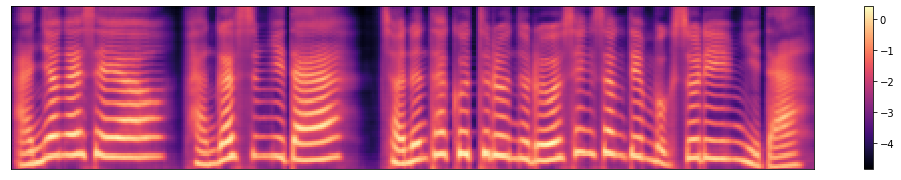

In [97]:
from dataset import get_utf8_values
import matplotlib.pyplot as plt
import librosa.display

tokens = get_utf8_values('안녕하세요? 반갑습니다. 저는 타코트론으로 생성된 목소리입니다.')
tokens = torch.LongTensor(tokens).cuda().unsqueeze(0)

model.eval()
with torch.no_grad():
    # (mel_outputs, mel_outputs_postnet, gate_outputs, alignments)
    outputs = model.inference(tokens)
_mel = outputs[1][0].data.cpu().numpy()

plt.figure(figsize=[18, 3])
librosa.display.specshow(_mel)
plt.colorbar()
plt.show()

(80, 400) (513, 80)


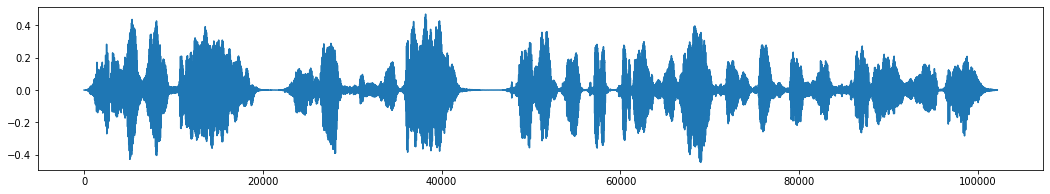

In [98]:
def mel_to_wav(mel):
    mel = 10 ** mel
    mel_matrix = librosa.filters.mel(sr=hparams.sampling_rate, 
                                              n_fft=hparams.win_length, 
                                              n_mels=hparams.n_mel_channels, 
                                              fmin=hparams.mel_fmin, 
                                              fmax=hparams.mel_fmax)
    inv_matrix = np.linalg.pinv(mel_matrix)
    print(mel.shape, inv_matrix.shape)
    S = inv_matrix @ mel
    wav = librosa.griffinlim(S, n_iter=32, hop_length=256, win_length=1024)
    
    return wav
    
_wav = mel_to_wav(_mel)

plt.figure(figsize=[18, 3])
plt.plot(_wav)
plt.show()

import IPython.display as ipd
ipd.Audio(_wav, rate=22050)

### Use ParallelWaveGAN to convert mel-spectrogram to wave

https://github.com/kan-bayashi/ParallelWaveGAN

In [91]:
from parallel_wavegan.utils import download_pretrained_model
from parallel_wavegan.utils import load_model

device='cuda'
vocoder_tag = "ljspeech_parallel_wavegan.v3"

# NOTE: Sometimes download is failed due to "Permission denied". That is 
#   the limitation of google drive. Please retry after serveral hours.
vocoder = load_model(download_pretrained_model(vocoder_tag)).to(device).eval()
vocoder.remove_weight_norm()

from parallel_wavegan.utils import read_hdf5

stats_filename = "/aiffel/.cache/parallel_wavegan/ljspeech_parallel_wavegan.v3/stats.h5"
mean = read_hdf5(stats_filename, 'mean')
scale = read_hdf5(stats_filename, 'scale')
print('done')


done


In [99]:
vocoder.eval()
with torch.no_grad():
    _mel = (_mel.T - mean) / scale
    mel = torch.from_numpy(_mel).cuda()
    wav = vocoder.inference(mel)
    _wav = wav[:, 0].data.cpu().numpy()
    
import IPython.display as ipd
ipd.Audio(_wav, rate=22050)
